# PN2V Prediction
Please run the `2_ProbabilisticNoise2VoidTraining.ipynb` notebook first.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import numpy as np
import torch
from tifffile import imread

from ppn2v.unet.model import UNet
from ppn2v import utils, prediction
from ppn2v.noise_models import histNoiseModel, gaussianMixtureNoiseModel

# See if we can use a GPU
device=utils.getDevice()

CUDA available? True


### Load Data

In [2]:
# We need the training data in order to calulate 'mean' and 'std' for normalization
path='../../../data/Mouse actin/'

# Load the test data
dataTest=imread(path+"sample_attempt2.tif")[:,:,:512] 
# We are loading only a sub image to speed up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]



### Load the Network and Noise Model

In [3]:
dataName = 'mouseactin'# Use the same name as used in 2_ProbabilisticNoise2VoidTraining.ipynb. This is a part of model name created in ProbabilisticNoise2VoidTraining.ipynb
# Load the noiseModel of interest 
nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'calibration'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'calibration'
# nameNoiseModel ='HistNoiseModel_'+dataName+'_'+'bootstrap'
# nameNoiseModel='GMMNoiseModel_'+dataName+'_'+str(3)+'_'+str(2)+'_'+'bootstrap'


In [4]:
namePN2VModel=nameNoiseModel
net=torch.load(path+"/last_"+namePN2VModel+".net")
if('HistNoiseModel' in namePN2VModel):
    histogram = np.load(path+nameNoiseModel+'.npy') 
    noiseModel= histNoiseModel.NoiseModel(histogram, device=device)
elif('GMMNoiseModel' in namePN2VModel):
    params= np.load(path+nameNoiseModel+'.npz')
    noiseModel = gaussianMixtureNoiseModel.GaussianMixtureNoiseModel(params = params, device = device)    

### Evaluation

image: 0
PSNR input 23.643400849264026
PSNR prior 33.36251163648623
PSNR mse 33.858382890847324
-----------------------------------
image: 1
PSNR input 23.620883803207068
PSNR prior 33.3732741939931
PSNR mse 33.87218240378548
-----------------------------------
image: 2
PSNR input 23.667113469021835
PSNR prior 33.427836132487954
PSNR mse 33.928413979472616
-----------------------------------
image: 3
PSNR input 23.64709110714436
PSNR prior 33.34760330388186
PSNR mse 33.828358737527026
-----------------------------------
image: 4
PSNR input 23.672914919463746
PSNR prior 33.3082594654647
PSNR mse 33.78142860239666
-----------------------------------
image: 5
PSNR input 23.669950605295924
PSNR prior 33.28274436031829
PSNR mse 33.75604722259072
-----------------------------------
image: 6
PSNR input 23.70231487515842
PSNR prior 33.41217272889912
PSNR mse 33.9185321181959
-----------------------------------
image: 7
PSNR input 23.705049534851174
PSNR prior 33.35330378342867
PSNR mse 33.8423

image: 63
PSNR input 23.720689613627076
PSNR prior 33.18708029551216
PSNR mse 33.650009489551174
-----------------------------------
image: 64
PSNR input 23.716027075591573
PSNR prior 33.24213497193292
PSNR mse 33.71680151338427
-----------------------------------
image: 65
PSNR input 23.73440771063101
PSNR prior 33.302301171460044
PSNR mse 33.78687039415099
-----------------------------------
image: 66
PSNR input 23.752612512661457
PSNR prior 32.94905663178342
PSNR mse 33.393674036112635
-----------------------------------
image: 67
PSNR input 23.76459996947784
PSNR prior 33.2252851733215
PSNR mse 33.69662806753095
-----------------------------------
image: 68
PSNR input 23.759235163477868
PSNR prior 33.182967676305836
PSNR mse 33.64752106868244
-----------------------------------
image: 69
PSNR input 23.745309084966966
PSNR prior 33.41287816288195
PSNR mse 33.90446832938454
-----------------------------------
image: 70
PSNR input 23.7092400215346
PSNR prior 33.03259266504344
PSNR mse

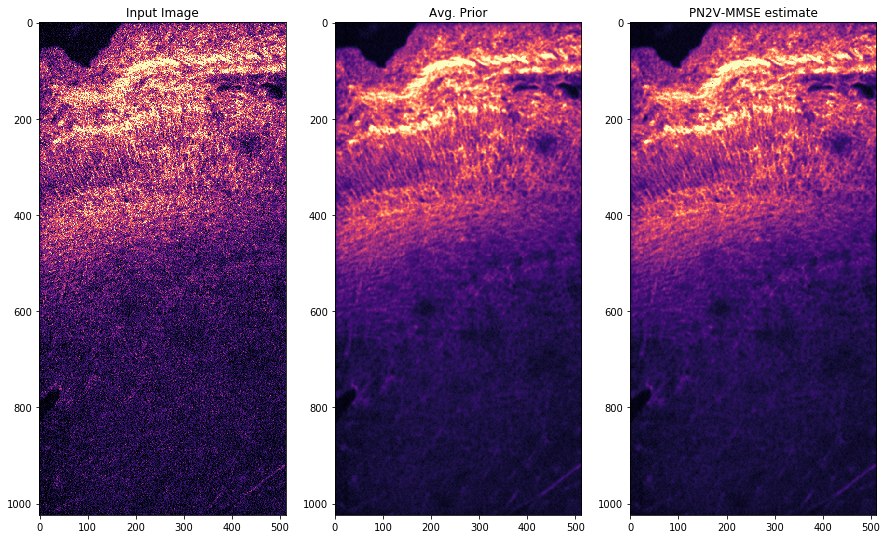

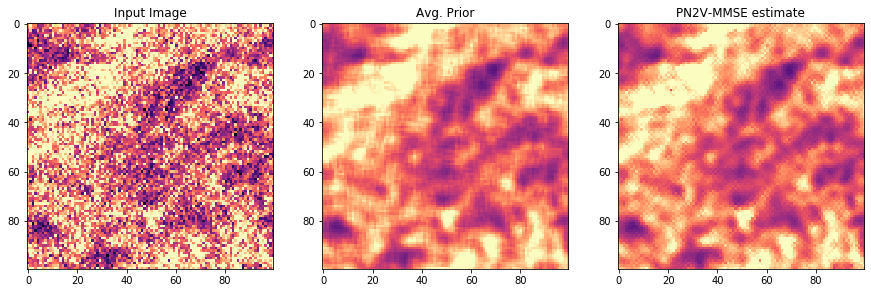

Avg PSNR Prior: 33.28137998943722 +-(2SEM) 0.022966061988734295
Avg PSNR MMSE: 33.75892975877898 +-(2SEM) 0.025761288150068444


In [5]:
# Now we are processing data and calculating PSNR values.
results=[]
meanRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    means, mseEst = prediction.tiledPredict(im, net, ps=128, overlap=48,
                                             device=device, noiseModel=noiseModel)

    
    resultImgs.append(mseEst)
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    psnr=utils.PSNR(gt, mseEst,rangePSNR )
    psnrPrior=utils.PSNR(gt, means,rangePSNR )
    results.append(psnr)
    meanRes.append(psnrPrior)

    print ("image:",index)
    print ("PSNR input",utils.PSNR(gt, im, rangePSNR))
    print ("PSNR prior",psnrPrior) # Without info from masked pixel
    print ("PSNR mse",psnr) # MMSE estimate using the masked pixel
    print ('-----------------------------------')

    
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst, vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/PN2VBootGMM.png', mseEst)
plt.show()

plt.figure(figsize=(15, 15))
plt.subplot(1, 3, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 2)
plt.title(label='Avg. Prior')
plt.imshow(means[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 3, 3)
plt.title(label='PN2V-MMSE estimate')
plt.imshow(mseEst[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/PN2VBootGMMSmall.png', mseEst[100:200,150:250])
plt.show()

print("Avg PSNR Prior:", np.mean(np.array(meanRes) ), '+-(2SEM)',2*np.std(np.array(meanRes) )/np.sqrt(float(len(meanRes)) ) )
print("Avg PSNR MMSE:", np.mean(np.array(results) ),  '+-(2SEM)' ,2*np.std(np.array(results) )/np.sqrt(float(len(results)) ) )